In [1]:
import os
import nibabel as nib
import cv2 as cv
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch

slices_excluir = "/home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/excluir-slices.txt"

t2flair_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T2flair-study"
t1w_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T1w-study"
roi_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/roi"

t2flair_nii_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T2flair-study-nii"
t1w_nii_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/T1w-study-nii"
roi_nii_path = "/home/mariopasc/Python/Datasets/ds-epilepsy/roi-nii"

t2flair_im_train_path = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/train"
t2flair_im_val_path = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/val"
t2flair_label_train_path = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/train"
t2flair_label_train_val = "/home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/val"

t1w_im_train_path = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/images/train"
t1w_im_val_path = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/images/val"
t1w_label_train_path = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/labels/train"
t1w_label_train_val = "/home/mariopasc/Python/Datasets/t1w-yolov8-ds/labels/val"

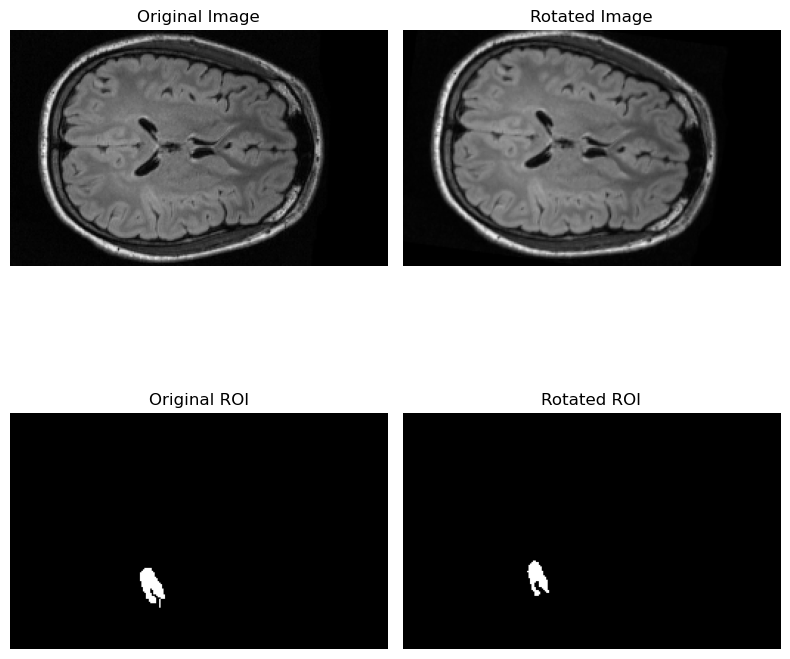

In [17]:
file_original = "sub-00073-161.nii"
file_rotated = "sub-00073-161-rotation.nii"

original_im = np.uint8(nib.load(os.path.join(t2flair_nii_path, file_original)).get_fdata())
rotated_im = np.uint8(nib.load(os.path.join(t2flair_nii_path, file_rotated)).get_fdata())
original_roi = np.uint8(nib.load(os.path.join(roi_nii_path, file_original)).get_fdata())
rotated_roi = np.uint8(nib.load(os.path.join(roi_nii_path, file_rotated)).get_fdata())

fig, axes = plt.subplots(2, 2, figsize=(8,9))
axes[0, 0].imshow(original_im, cmap="gray")
axes[0, 0].axis('off')
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(original_roi, cmap="gray")
axes[1, 0].axis('off')
axes[1, 0].set_title("Original ROI")

axes[0, 1].imshow(rotated_im, cmap="gray")
axes[0, 1].axis('off')
axes[0, 1].set_title("Rotated Image")
axes[1, 1].imshow(rotated_roi, cmap="gray")
axes[1, 1].axis('off')
axes[1, 1].set_title("Rotated ROI")

plt.tight_layout()
plt.show()

### Data Loader - Convertir .nii.gz a imágenes PNG o JPEG2000

Workflow actual: 

1. Convertir el estudio dado a .nii. La carpeta del estudio dado debe tener en su interior carpetas con el nombre del paciente "sub-00XXXX" y, dentro de esas carpetas, debe estar el archivo .nii.gz. Se puede dar como argumento un .txt con rodajas que se excluirán de convertir a .nii. 
2. Realizar el hold-out de los datos. Los archivos .nii dedicados a train, val y test serán guardados en 3 archivos .txt. Estos archivos serán recibidos como entrada en la función que convierte los archivos .nii a PNG (paso 3) y las redirigirá a sus respectivas carpetas. 
3. Convertir el estudio en .nii a un formato sin pérdidas. Se ha implementado una normalización provisional dentro de este método. En un futuro, cuando se aplique un preprocesamiento a las rodajas del archivo .nii.gz, esta normalización ya vendrá dada. 

**Detalles**

- La función que se encarga de convertir las imágenes a PNG y moverlas a los directorios de train/val/test especificados por el holdout recibe como entrada un archivo .txt con los detalles de todos los paths donde puede encontrar la información. Este txt debe tener un formato como:
```bash
niiFolder: /home/mariopasc/Python/Datasets/ds-epilepsy/T2flair-study-nii
trainFolder: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/train
trainNiiFiles: /home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/t2flair-study/holdout/train_files.txt
valFolder: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/val
valNiiFIles: /home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/t2flair-study/holdout/val_files.txt
testFolder: /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/images/test
testNiiFiles: /home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/text-info-files/t2flair-study/holdout/test_files.txt
format: PNG
```

In [69]:
from ultralytics import YOLO
yaml = "/home/mariopasc/Python/Projects/BSC_final/epilepsy-displasia-focal-segmentation/info-files/t2flair-study/config.yaml"
model = YOLO(model = "yolov8n-seg.pt",
             task='segment')
results_train = model.train(data=yaml, epochs=3, imgsz=640, project="a" ,
                                         save=True, save_period=1,
                                         name="Yolov8-Train", verbose=True,
                                         seed=42, single_cls=True, plots=False,
                                         augment=False, hsv_h=0.0, hsv_s=0.0, hsv_v=0.0, degrees=0.0, translate=0.0,
                                         scale=0.0, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.0, mosaic=0.0,
                                         close_mosaic=0, mixup=0.0, copy_paste=0.0, auto_augment="", erasing=0.0, val=False)
results_val = model.val(data=yaml, imgsz=640, conf=0.001, plots=True, save_json=True)

Ultralytics YOLOv8.1.25 🚀 Python-3.8.18 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
YOLOv8n-seg summary (fused): 195 layers, 3404320 parameters, 0 gradients, 12.6 GFLOPs


val: Scanning /home/mariopasc/Python/Datasets/t2flair-yolov8-ds/labels/val.cache... 469 images, 1853 backgrounds, 0 corrupt: 100%|██████████| 2322/2322 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  22%|██▏       | 32/146 [00:06<00:26,  4.30it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71c955883790>
Traceback (most recent call last):
  File "/home/mariopasc/Python/miniconda3/envs/torch_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/mariopasc/Python/miniconda3/envs/torch_env/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/mariopasc/Python/miniconda3/envs/torch_env/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)

KeyboardInterrupt: 